In [1]:
import numpy as np 
import pandas as pd
import csv
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
import emoji
import string
import json
import nltk

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# list of all the dataset files

dataset_paths = ["/INET/state-trolls/work/state-trolls/datasets/russia_052020_tweets_csv_hashed_2.csv", 
         "/INET/state-trolls/work/state-trolls/datasets/russian_linked_tweets_csv_hashed.csv", 
         "/INET/state-trolls/work/state-trolls/datasets/ira_tweets_csv_hashed.csv", 
         "/INET/state-trolls/work/state-trolls/datasets/russia_201906_1_tweets_csv_hashed.csv"]

# path to store the entire combined dataset
combined_dataset_path = "../datasets/russian_trolls.csv"

# returns a pandas dataframe consisting of entries from all the dataset files
def get_combined_dataset(paths):
    data = pd.concat((pd.read_csv(file) for file in tqdm(paths)))
    return data

data = get_combined_dataset(dataset_paths)
print("Number of tweets in the dataset: ", data.shape[0])

# extracts just the english tweets by using the language tag
is_english_tweet = data['tweet_language'] == 'en'
english_data = data[is_english_tweet]

print("Number of English tweets in the dataset: ", english_data.shape[0])
english_tweet_data = english_data[['tweetid', 'tweet_text']]

# takes list of tweets as input and returns list of pre-processed tweets as output
def preprocess(tweets):
    processed_tweets = []
    for tweet in tweets:
        result = re.sub(r"http\S+", "", tweet)
        result = re.sub(r"RT @\S+", "", result)
        result = re.sub(r"@\S+", "", result)
        result = re.sub(emoji.get_emoji_regexp(), "", result)
        result_removed_punctuation = result.translate(str.maketrans('', '', string.punctuation))
        result = re.sub(r"[^a-zA-Z0-9 ]", "", result_removed_punctuation)
        processed_tweets.append(result)
    return processed_tweets

# Filtering data between 01.01.2019 to 01.07.2017
data['tweet_time'] = pd.to_datetime(data['tweet_time'], format = '%Y-%m-%d')
start_date = '2016-01-01'
end_date = '2017-07-01'
mask = (data['tweet_time'] > start_date) & (data['tweet_time'] <= end_date)
data = data.loc[mask]
print("Number of tweets in the dataset after filtering: ", data.shape[0])


# extracts just the english tweets by using the language tag
is_english_tweet = data['tweet_language'] == 'en'
f_english_data = data[is_english_tweet]
print("Number of English tweets in the filtered dataset: ", f_english_data.shape[0])
f_english_tweet_data = f_english_data[['tweetid', 'tweet_text']]

tweets = f_english_tweet_data['tweet_text']
tweets = preprocess(tweets)

f_english_tweet_data = f_english_tweet_data.assign(processed_tweets = tweets)

# removes the entries having empty string after preprocessing
is_not_empty_string = f_english_tweet_data['processed_tweets'].apply(lambda x: not str.isspace(x))
f_english_tweet_data = f_english_tweet_data[is_not_empty_string]
print("Number of english tweets after filtering and preprocessing before dropping the duplicates: ", f_english_tweet_data.shape[0])
f_english_tweet_data.drop_duplicates(subset ="tweetid", keep = 'first', inplace = True) 
f_english_tweet_data = f_english_tweet_data.reset_index()
print("Number of english tweets after filtering and preprocessing and dropping the duplicates: ", f_english_tweet_data.shape[0])
twitter_data = f_english_tweet_data


100%|██████████| 4/4 [00:54<00:00, 13.60s/it]


Number of tweets in the dataset:  9995700
Number of English tweets in the dataset:  3739633
Number of tweets in the dataset after filtering:  3170632
Number of English tweets in the filtered dataset:  1759076
Number of english tweets after filtering and preprocessing before dropping the duplicates:  1757447
Number of english tweets after filtering and preprocessing and dropping the duplicates:  1662395


In [2]:
# ## Set up of PysSpark dataframe for Reddit Data
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import col, asc

# You can configure the SparkContext

conf = SparkConf()
conf.set('spark.local.dir', '/INET/state-trolls/work/state-trolls/poc/')
conf.set('spark.sql.shuffle.partitions', '2100')
SparkContext.setSystemProperty('spark.executor.memory', '10g')
SparkContext.setSystemProperty('spark.driver.memory', '10g')
sc = SparkContext(appName='mm_exp', conf=conf)
sqlContext = pyspark.SQLContext(sc)

In [95]:
reddit_data = sqlContext.read.json('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/RC_2016-03.bz2.decompressed')

In [15]:
import math
import glob
import json
range_counts = np.zeros(10)
l = np.empty((10, 0)).tolist()
f = []

In [ ]:
i = 0
for name in glob.glob('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/annotations/formatted/RC_2016-03*'):
    print(i)
    with open(name, 'r') as read_file:
        jdata = json.load(read_file)
        df = pd.DataFrame(jdata)
        sample_df = df.sample(n = 17000)
        post_id = df.iloc[0]['post_id']
        post = reddit_data.where((col("id") == post_id)).collect()[0]
        for index, row in sample_df.iterrows():
            cos_sim = row['cosine_similarity']
            cos_sim = float(cos_sim)
            tweet_id = row['tweet_id']
            tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
            tweet_text = tweet.iloc[0]['processed_tweets']
            range_index = 0
            if (cos_sim > 0):
                range_index = math.floor(cos_sim*10)
            if (cos_sim > 1):
                range_index = 9
            if (range_counts[range_index] < 50):
                range_counts[range_index] = range_counts[range_index] + 1
                d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim, 's_id': row['s_id']}
                l[range_index].append(d)
    i = i + 1
    print(range_counts)              

In [ ]:
f.append(l)

In [ ]:
i = 0
for name in glob.glob('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/annotations/formatted/RC_2016-03*'):
    if(range_counts[5] >1500 ):
        break
    print(i)
    with open(name, 'r') as read_file:
        jdata = json.load(read_file)
        df = pd.DataFrame(jdata)
        df = df.astype({'cosine_similarity':float})
        selected_df = df.loc[(df['cosine_similarity'] > 0.5) & (df['cosine_similarity'] <= 0.6)]
        print('len: ', len(selected_df))
        if(len(selected_df) > 1000):
            selected_df = selected_df.sample(n = 1000)
        if (len(selected_df)>0):
            post_id = df.iloc[0]['post_id']
            print(post_id)
            post = reddit_data.where((col("id") == post_id)).collect()[0]
            for index, row in selected_df.iterrows():
                cos_sim = row['cosine_similarity']
                cos_sim = float(cos_sim)
                tweet_id = row['tweet_id']
                tweet = twitter_data.loc[twitter_data['tweetid'] == int(tweet_id)]
                tweet_text = tweet.iloc[0]['processed_tweets']
                range_index = 0
                if (cos_sim > 0):
                    range_index = math.floor(cos_sim*10)
                if (cos_sim > 1):
                    range_index = 9
                if (range_counts[range_index] < 1500):
                    range_counts[range_index] = range_counts[range_index] + 1
                    d = {'tweet': tweet_text, 'post': post['body'], 'sim': cos_sim, 's_id': row['s_id']}
                    l[range_index].append(d)
        i = i + 1
           

In [108]:
import random

f= []
for e in l:
    r = random.sample(e, 50)
    for i in r:
        f.append(i)

In [109]:
len(f)

500

In [110]:
random.shuffle(f)
f_df = pd.DataFrame(f)
# f_df.head()

s = []
for index, row in f_df.iterrows():
    post_text = row['post']
    sentences = nltk.sent_tokenize(post_text)  
    sentence = sentences[row['s_id']]
    s.append(sentence)
print(len(s))
f_df = f_df.assign(post_sentence = s)
f_df.head()

500


,tweet,post,sim,s_id,post_sentence
0,ItsTheEndOfTheWorldAnd I cant be bothered bec...,My point is that teams are making moves to fil...,0.498970,2,If your only reason for being good is that not...
1,Thank you,Thank you :),0.998981,0,Thank you :)
2,Thanks for holding,Thanks. I'll be sure to post similar things to...,0.711844,0,Thanks.
3,This is so unfair,I talked to a friend who owns a couple Chinese...,0.680722,9,And she ain't wrong.
4,thank you,Thanks. I'll be sure to post similar things to...,0.912710,0,Thanks.


In [111]:
f_df.to_csv('stsb_500_random_hits_v2.csv')

# Matrix for threshold analysis

In [293]:
m_df = pd.read_csv('/INET/state-trolls/work/state-trolls/poc/stsb-roberta-large/stsb_500_random_hits_v2.csv')
m_df2 = pd.read_csv('/INET/state-trolls/work/state-trolls/poc/stsb-roberta-large/stsb_copy1.csv') 

In [298]:
annotation_df = pd.DataFrame()
annotation_df['annotation'] = m_df2['final_annotation']
annotation_df['cos-sim'] = m_df['sim']

In [300]:
matrix_0 = []
matrix_1 = []
from sklearn.metrics import classification_report
target_names = ['irrelevant', 'relevant']
for threshold in np.arange(0.05, 1.0, 0.05):
    annotation_df['true-values'] = np.where(annotation_df['cos-sim'] > threshold, 1, 0)
    c = classification_report(annotation_df['true-values'],
                              annotation_df['annotation'], target_names=target_names, output_dict = True)
    matrix_0.append({'threshold': threshold, 'class': '0',
                   'precision' : (c['irrelevant'])['precision'],
                  'recall': (c['irrelevant'])['recall'],
                  'f1-score': (c['irrelevant'])['f1-score'],
                  'support': (c['irrelevant'])['support'],
                  'accuracy': c['accuracy']})
    matrix_1.append({'threshold': threshold, 'class': '1',
                   'precision' : (c['relevant'])['precision'],
                  'recall': (c['relevant'])['recall'],
                  'f1-score': (c['relevant'])['f1-score'],
                  'support': (c['relevant'])['support'],
                  'accuracy': c['accuracy']})
#     print(c)

In [302]:
pd.DataFrame(matrix_1).to_csv('threshold-analysis-matrix-combined.csv')

# Important tweet Analysis

In [317]:
import numpy as np 
import pandas as pd
import string
import json
import glob
import os


with open('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/scores/RC_2016-01.bz2.decompressed/1_scores_stsb.txt', 'r') as content_file:
    content = content_file.read()
    json_data = content.replace('][',',')
    j_object = json.loads(json_data)

with open('/INET/state-trolls/work/state-trolls/reddit_dataset/comments/j.json', 'w') as fout:
    json.dump(j_object, fout)



In [367]:
import collections
j_df = pd.DataFrame(j_object)
counts = collections.Counter(j_df['tweet_id'].tolist())
counts_sorted = counts.most_common()
c_df = pd.DataFrame(counts_sorted, columns=['tweet_id', 'frequency'])

In [ ]:
dicts = []
for item in counts_sorted: 
    text = (f_english_tweet_data.loc[f_english_tweet_data['tweetid'] == item[0]])['processed_tweets']
    dicts.append({'text': text, 'count': item[1]})

/INET/state-trolls/work/state-trolls/miniconda3/envs/env3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  


Text(0, 0.5, 'Fits hits of 10k posts')

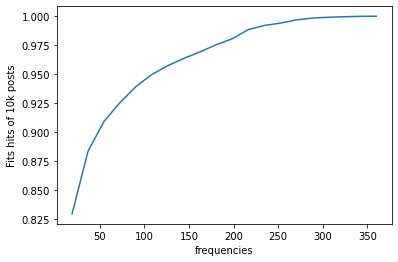

In [369]:
frequencies = c_df['frequency'].to_list()
counts, bin_edges = np.histogram (frequencies, bins=20, normed=False)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('frequencies')
plt.ylabel('Fits hits of 10k posts')

In [371]:
c_df.keys()

Index(['tweet_id', 'frequency'], dtype='object')